In [ ]:
!pip install datasets transformers[torch] seqeval deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 31.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1

In [ ]:
from datasets import load_from_disk
dataset = load_from_disk("drive/MyDrive/ner_dataset_conll_format_impression_yok")

In [ ]:
#model_names = ["sezinarseven/turkish-medical-field-detection-8","dbmdz/convbert-base-turkish-cased","busecarik/berturk-sunlp-ner-turkish","savasy/bert-base-turkish-ner-cased","dbmdz/convbert-base-turkish-mc4-cased","dbmdz/bert-base-turkish-cased","google-bert/bert-base-multilingual-cased","dbmdz/distilbert-base-turkish-cased","Buseak/penn_berturk_0203_v5","Buseak/model_from_berturk_Feb_5_TrainTestSplit","alierenak/berturk_cased_ner"]
model_names = ["dbmdz/convbert-base-turkish-cased","dbmdz/convbert-base-turkish-mc4-cased","dbmdz/bert-base-turkish-cased","dbmdz/distilbert-base-turkish-cased","Buseak/penn_berturk_0203_v5","Buseak/model_from_berturk_Feb_5_TrainTestSplit","alierenak/berturk_cased_ner"]#,"google-t5/t5-large"]#,"google-t5/t5-base"]
MODEL_PATH = "/content/drive/MyDrive/ner_model_"#"savasy/bert-base-turkish-ner-cased",

In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
tokenizers = [AutoTokenizer.from_pretrained(model_name) for model_name in model_names]

In [ ]:
def tokenize_and_align_labels(examples, label_all_tokens=True):
    tokenized_inputs = cur_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets_list = []
for i in range(len(tokenizers)):
  cur_tokenizer = tokenizers[i]
  a = dataset.map(tokenize_and_align_labels, batched=True)
  tokenized_datasets_list.append(a)


In [ ]:
import datasets
metric = datasets.load_metric("seqeval",trust_remote_code=True)
label_list = dataset["train"].features["ner_tags"].feature.names

In [ ]:
import numpy as np
def compute_metrics(eval_preds):
    """
    Function to compute the evaluation metrics for Named Entity Recognition (NER) tasks.
    The function computes precision, recall, F1 score and accuracy.

    Parameters:
    eval_preds (tuple): A tuple containing the predicted logits and the true labels.

    Returns:
    A dictionary containing the precision, recall, F1 score and accuracy.
    """
    pred_logits, labels = eval_preds

    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]

    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
   ]
    results = metric.compute(predictions=predictions, references=true_labels)
    return {
   "precision": results["overall_precision"],
   "recall": results["overall_recall"],
   "f1": results["overall_f1"],
  "accuracy": results["overall_accuracy"],
    }

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_score,recall_score,accuracy_score
def compute_metrics2(eval_preds):
    """
    Function to compute the evaluation metrics for Named Entity Recognition (NER) tasks.
    The function computes precision, recall, F1 score and accuracy.

    Parameters:
    eval_preds (tuple): A tuple containing the predicted logits and the true labels.

    Returns:
    A dictionary containing the precision, recall, F1 score and accuracy.
    """
    pred_logits, labels = eval_preds

    pred_logits = np.argmax(pred_logits, axis=2)
    # the logits and the probabilities are in the same order,
    # so we don’t need to apply the softmax

    # We remove all the values where the label is -100
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_logits, labels)
    ]

    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_logits, labels)
   ]

    true_labels_flat = [label for sublist in true_labels for label in sublist]
    pred_labels_flat = [label for sublist in predictions for label in sublist]

    f1 = f1_score(true_labels_flat, pred_labels_flat, average='weighted')
    precision = precision_score(true_labels_flat, pred_labels_flat, average='weighted')
    recall = recall_score(true_labels_flat, pred_labels_flat, average='weighted')
    accuracy = accuracy_score(true_labels_flat, pred_labels_flat)

    return {
   "precision": precision,
   "recall": recall,
   "f1": f1,
  "accuracy": accuracy,
    }



In [ ]:
# from transformers import T5ForTokenClassification, T5Config
# import json
# # Step 2: Define your model path
# MODEL_PATH2 = '/content/drive/MyDrive/ner_model_google-t5_t5-large/'

# # Step 3: Load adapter configuration
# with open(MODEL_PATH2 + 'adapter_config.json', 'r') as f:
#     adapter_config = json.load(f)

# # Step 4: Create a new T5 configuration and update it with adapter config
# config = T5Config.from_pretrained('t5-large')
# config.num_labels = 6  # Update the number of labels if needed
# config.update(adapter_config)  # Update with adapter config if needed

# # Save this new configuration temporarily
# with open(MODEL_PATH2 + 'config.json', 'w') as f:
#     json.dump(config.to_dict(), f)

# # Step 5: Load the model with the custom configuration
# model = T5ForTokenClassification.from_pretrained(MODEL_PATH2, config=config)

In [ ]:
from transformers import DataCollatorForTokenClassification,Trainer
model_loaded_list = [AutoModelForTokenClassification.from_pretrained(MODEL_PATH + model_name.replace("/","_")+"_impression_yok") for model_name in model_names]
trainer_list = [Trainer(
    model=model_loaded_list[i],
    data_collator=DataCollatorForTokenClassification(tokenizers[i]),
    tokenizer=tokenizers[i],
    compute_metrics=compute_metrics2,
) for i in range(len(model_loaded_list))]
#trainer_list.append(t)

In [ ]:
prediction_list = [trainer_list[i].predict(tokenized_datasets_list[i]["test"]).predictions for i in range(len(trainer_list))]

In [ ]:
trainer_list[6].evaluate(tokenized_datasets_list[3]["test"])

{'eval_loss': 0.5848101377487183,
 'eval_precision': 0.8857173940725485,
 'eval_recall': 0.8835737291695841,
 'eval_f1': 0.882624619740858,
 'eval_accuracy': 0.8835737291695841,
 'eval_runtime': 2.0979,
 'eval_samples_per_second': 119.168,
 'eval_steps_per_second': 15.253}

In [ ]:
for i in range(len(prediction_list)):
  if prediction_list[i].shape[1] == 302:
    print(i, model_names[i])

0 dbmdz/convbert-base-turkish-cased
1 dbmdz/convbert-base-turkish-mc4-cased
2 dbmdz/bert-base-turkish-cased
3 dbmdz/distilbert-base-turkish-cased
4 Buseak/penn_berturk_0203_v5
5 Buseak/model_from_berturk_Feb_5_TrainTestSplit
6 alierenak/berturk_cased_ner


In [ ]:
import random
from deap import base, creator, tools, algorithms
# Define the evaluation function
def evaluate(individual):
    x1, x2, x3, x4, x5, x6, x7 = individual
    # Replace this with your actual function
    #coef_list = random_floats_summing_to_one(8).tolist()
    coef_list = [x1,x2,x3,x4,x5,x6,x7]
    combined_test_preds_proba = prediction_list[0]*coef_list[0]
    for i in range(1,len(prediction_list)):
      combined_test_preds_proba += prediction_list[i]*coef_list[i]
    test_labels = tokenized_datasets_list[1]["test"]["labels"]
    result_f1 = compute_metrics2((combined_test_preds_proba,test_labels))["f1"]
    return (result_f1,)

In [ ]:
# Normalize weights to sum to 1
def normalize_weights(individual):
    total = sum(individual)
    return [x / total for x in individual]

In [ ]:
# Create the fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the toolbox
toolbox = base.Toolbox()

# Attribute generator with normalization
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initIterate, creator.Individual,
                 lambda: normalize_weights([random.uniform(0, 1) for _ in range(7)]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the evaluation function
toolbox.register("evaluate", evaluate)

# Register the genetic operators
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [ ]:
import multiprocessing
from scipy.optimize import differential_evolution

# Genetic Algorithm parameters
population_size = 300
generations = 30
crossover_probability = 0.7
mutation_probability = 0.2

# Parallelization setup
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

# Create the initial population
population = toolbox.population(n=population_size)

# Apply the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability,
                    ngen=generations, verbose=True)

# Close the pool
pool.close()
pool.join()

# Extract the best individual after the optimization
best_individual = tools.selBest(population, k=1)[0]
print('Best individual:', best_individual)
print('Best fitness:', best_individual.fitness.values[0])

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


gen	nevals
0  	300   
1  	219   
2  	243   
3  	224   
4  	233   
5  	241   
6  	233   
7  	233   
8  	224   
9  	226   
10 	213   
11 	220   
12 	233   
13 	223   
14 	230   
15 	239   
16 	241   
17 	225   
18 	220   
19 	231   
20 	236   
21 	237   
22 	231   
23 	231   
24 	233   
25 	222   
26 	241   
27 	232   
28 	251   
29 	235   
30 	234   
Best individual: [0.2854529235247392, 0.19650109752606754, -0.0047669377160449375, 0.16932072305113405, 0.26525141624644455, 0.19304691733812612, 0.07072168674348048]
Best fitness: 0.893501461018367


In [ ]:
# Differential Evolution for fine-tuning (optional)
bounds = [(0, 1)] * 7  # Weights should be between 0 and 1

def objective_function(x):
    return -evaluate(normalize_weights(x))[0]  # scipy minimizes, so we negate the function

maxf1 = 0.8542522921277268
# Create an initial population for differential evolution
init_list = tools.selBest(population,k=5)
init_pop = [normalize_weights(ind) for ind in init_list]
#init_pop.append([0.2701229388064353, 0.018376627801766326, 0.18654333677741633, 0.027010200174745983, 0.1867497066121902, 0.1428079058570163, 0.10382656866204815, 0.06456271530838141])
for i in range(10):
  result = differential_evolution(objective_function, bounds, init=init_pop, maxiter=100000)
  best_weights_de = normalize_weights(result.x)
  if -result.fun > maxf1:
    maxf1 = -result.fun
    print("qwe")
  print('Iteration', i+1)
  print('Best individual after DE:', best_weights_de)
  print('Best fitness after DE:', -result.fun)

qwe
Iteration 1
Best individual after DE: [0.23458960413679883, 0.17551314482493738, 0.014586526364856358, 0.1404760747451184, 0.2389202088982896, 0.15089811566924674, 0.045016325360752736]
Best fitness after DE: 0.8934491530034996
qwe
Iteration 2
Best individual after DE: [0.2346441490550527, 0.1716283241495124, 0.014589917908531563, 0.14050873713031567, 0.24650854469047823, 0.15093320130492155, 0.04118712576118782]
Best fitness after DE: 0.8934500554617636
Iteration 3
Best individual after DE: [0.2359746960109899, 0.17311896118228493, 0.01467264987069106, 0.14154725349212133, 0.2403308700447745, 0.15061815570909307, 0.04373741369004516]
Best fitness after DE: 0.8934491530034996
Iteration 4
Best individual after DE: [0.23458960413679883, 0.17551314482493738, 0.014586526364856358, 0.1404760747451184, 0.2389202088982896, 0.15089811566924674, 0.045016325360752736]
Best fitness after DE: 0.8934491530034996
Iteration 5
Best individual after DE: [0.23458960413679883, 0.17551314482493738, 0.

Best individual after DE: [0.19216606883690696, 0.05711875976084878, 0.16041094677313425, 0.11216093956033371, 0.2100303430740878, 0.0997232508298396, 0.0915565359309, 0.07683315523394867]
Best fitness after DE: 0.8489082969432314

Best individual after DE: [0.2346441490550527, 0.1716283241495124, 0.014589917908531563, 0.14050873713031567, 0.24650854469047823, 0.15093320130492155, 0.04118712576118782]
Best fitness after DE: 0.8934500554617636

## seqevalyok

Best individual after DE: [0.2529464501140743, 0.0, 0.16323932504445537, 0.009447688259989031, 0.14391147673661683, 0.1864209528109444, 0.17144043981143, 0.07259366722248987]
Best fitness after DE: 0.8933017932392076

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,f1_score,precision_score,recall_score,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
def compute_metrics_with_conf_matrix(eval_preds):
    """
    Function to compute the evaluation metrics for Named Entity Recognition (NER) tasks.
    The function computes precision, recall, F1 score, accuracy, and confusion matrix.

    Parameters:
    eval_preds (tuple): A tuple containing the predicted logits and the true labels.
    label_list (list): A list of all possible labels.

    Returns:
    A dictionary containing the precision, recall, F1 score, accuracy, and confusion matrix.
    """
    pred_logits, labels = eval_preds

    # Apply argmax to the predicted logits to get the predicted labels
    pred_labels = np.argmax(pred_logits, axis=2)

    # Prepare predictions and true labels for seqeval
    predictions = [
        [label_list[eval_preds] for (eval_preds, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(pred_labels, labels)
    ]

    true_labels = [
      [label_list[l] for (eval_preds, l) in zip(prediction, label) if l != -100]
       for prediction, label in zip(pred_labels, labels)
   ]

    # Compute seqeval metrics
    #results = metric.compute(predictions=predictions, references=true_labels)

    # Flatten lists for confusion matrix
    true_labels_flat = [label for sublist in true_labels for label in sublist]
    pred_labels_flat = [label for sublist in predictions for label in sublist]

    f1 = f1_score(true_labels_flat, pred_labels_flat, average='weighted')
    precision = precision_score(true_labels_flat, pred_labels_flat, average='weighted')
    recall = recall_score(true_labels_flat, pred_labels_flat, average='weighted')
    accuracy = accuracy_score(true_labels_flat, pred_labels_flat)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels_flat, pred_labels_flat, labels=label_list)
    conf_matrix = conf_matrix/sum(conf_matrix)
    print(classification_report(true_labels_flat, pred_labels_flat, target_names=label_list,digits=5))
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, xticklabels=label_list, yticklabels=label_list,cmap="Blues")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return {
   "precision": precision,
   "recall": recall,
   "f1": f1,
  "accuracy": accuracy,
    }

               precision    recall  f1-score   support

            O    0.88684   0.95970   0.92183      8362
         ANAT    0.92888   0.81919   0.87059     13583
  OBS-PRESENT    0.86609   0.97137   0.91572      4541
OBS-UNCERTAIN    0.87588   0.91001   0.89262      9034
   OBS-ABSENT    0.75758   0.81081   0.78329       185

     accuracy                        0.89438     35705
    macro avg    0.86305   0.89421   0.87681     35705
 weighted avg    0.89675   0.89438   0.89345     35705



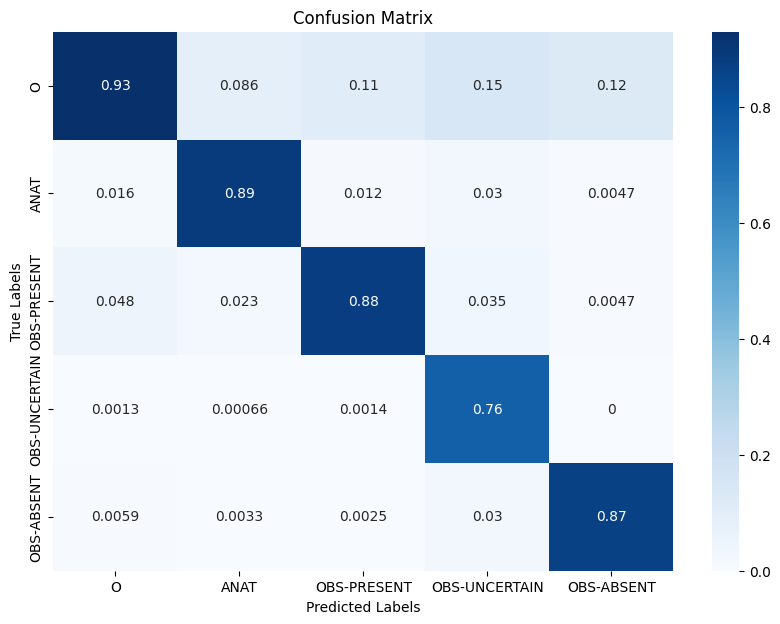

{'precision': 0.8967488718473344, 'recall': 0.8943845399803949, 'f1': 0.8934500554617636, 'accuracy': 0.8943845399803949}


In [ ]:
coef_list = [0.2346441490550527, 0.1716283241495124, 0.014589917908531563, 0.14050873713031567, 0.24650854469047823, 0.15093320130492155, 0.04118712576118782]
combined_test_preds_proba = prediction_list[0]*coef_list[0]
for i in range(1,len(coef_list)):
  combined_test_preds_proba += prediction_list[i]*coef_list[i]
test_labels = tokenized_datasets_list[1]["test"]["labels"]
result_f1 = compute_metrics_with_conf_matrix((combined_test_preds_proba,test_labels))
print(result_f1)

In [ ]:
for i in range(len(model_names)):
  print(model_names[i] + str(compute_metrics_with_conf_matrix((prediction_list[i],test_labels))))

dbmdz/convbert-base-turkish-cased{'precision': 0.8841978555268938, 'recall': 0.8837137655790506, 'f1': 0.8831126880089364, 'accuracy': 0.8837137655790506}
savasy/bert-base-turkish-ner-cased{'precision': 0.8838903284646512, 'recall': 0.8810810810810811, 'f1': 0.8797721987329598, 'accuracy': 0.8810810810810811}
dbmdz/convbert-base-turkish-mc4-cased{'precision': 0.8826339221428284, 'recall': 0.8753956028567428, 'f1': 0.8733315810408983, 'accuracy': 0.8753956028567428}
dbmdz/bert-base-turkish-cased{'precision': 0.8880127932156088, 'recall': 0.885674275311581, 'f1': 0.8847302272801759, 'accuracy': 0.885674275311581}
dbmdz/distilbert-base-turkish-cased{'precision': 0.8840328817567008, 'recall': 0.8821453577930262, 'f1': 0.881240008651113, 'accuracy': 0.8821453577930262}
Buseak/penn_berturk_0203_v5{'precision': 0.8892508284752364, 'recall': 0.8877748214535779, 'f1': 0.886908411423112, 'accuracy': 0.8877748214535779}
Buseak/model_from_berturk_Feb_5_TrainTestSplit{'precision': 0.885332125554496

## 8 models, GA with 300 pop 30 gen, and then Differential Evolution
model_names = ["dbmdz/convbert-base-turkish-cased","savasy/bert-base-turkish-ner-cased","dbmdz/convbert-base-turkish-mc4-cased","dbmdz/bert-base-turkish-cased","dbmdz/distilbert-base-turkish-cased","Buseak/penn_berturk_0203_v5","Buseak/model_from_berturk_Feb_5_TrainTestSplit","alierenak/berturk_cased_ner"]

coef_list = [0.2701229388064353, 0.018376627801766326, 0.18654333677741633, 0.027010200174745983, 0.1867497066121902, 0.1428079058570163, 0.10382656866204815, 0.06456271530838141]


{'precision': 0.8165359082679541, 'recall': 0.8972148541114059, **'f1': 0.8549763033175356**, 'accuracy': 0.8975970799959444}

In [ ]:
from transformers import T5ForTokenClassification, T5Config
import json
# Step 2: Define your model path
MODEL_PATH1 = '/content/drive/MyDrive/ner_model_google-t5_t5-large/'

# Step 3: Load adapter configuration
with open(MODEL_PATH1 + 'adapter_config.json', 'r') as f:
    adapter_config = json.load(f)

# Step 4: Create a new T5 configuration and update it with adapter config
config = T5Config.from_pretrained('t5-large')
config.num_labels = 6  # Update the number of labels if needed
config.update(adapter_config)  # Update with adapter config if needed

# Save this new configuration temporarily
with open(MODEL_PATH1 + 'config.json', 'w') as f:
    json.dump(config.to_dict(), f)

# Step 5: Load the model with the custom configuration
model1 = T5ForTokenClassification.from_pretrained(MODEL_PATH1, config=config)

Some weights of T5ForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/ner_model_google-t5_t5-large/ and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.block.0.layer.0.SelfAttention.k.weight', 'encoder.block.0.layer.0.SelfAttention.o.weight', 'encoder.block.0.layer.0.SelfAttention.q.weight', 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'encoder.block.0.layer.0.SelfAttention.v.weight', 'encoder.block.0.layer.0.layer_norm.weight', 'encoder.block.0.layer.1.DenseReluDense.wi.weight', 'encoder.block.0.layer.1.DenseReluDense.wo.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.0.SelfAttention.k.weight', 'encoder.block.1.layer.0.SelfAttention.o.weight', 'encoder.block.1.layer.0.SelfAttention.q.weight', 'encoder.block.1.layer.0.SelfAttention.v.weight', 'encoder.block.1.layer.0.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wi.weight', 'encoder.block.1.layer.1.

In [ ]:
# Step 2: Define your model path
MODEL_PATH2 = '/content/drive/MyDrive/ner_model_google-t5_t5-base/'

# Step 3: Load adapter configuration
with open(MODEL_PATH2 + 'adapter_config.json', 'r') as f:
    adapter_config = json.load(f)

# Step 4: Create a new T5 configuration and update it with adapter config
config = T5Config.from_pretrained('t5-base')
config.num_labels = 6  # Update the number of labels if needed
config.update(adapter_config)  # Update with adapter config if needed

# Save this new configuration temporarily
with open(MODEL_PATH2 + 'config.json', 'w') as f:
    json.dump(config.to_dict(), f)

# Step 5: Load the model with the custom configuration
model2 = T5ForTokenClassification.from_pretrained(MODEL_PATH2, config=config)

Some weights of T5ForTokenClassification were not initialized from the model checkpoint at /content/drive/MyDrive/ner_model_google-t5_t5-base/ and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.block.0.layer.0.SelfAttention.k.weight', 'encoder.block.0.layer.0.SelfAttention.o.weight', 'encoder.block.0.layer.0.SelfAttention.q.weight', 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'encoder.block.0.layer.0.SelfAttention.v.weight', 'encoder.block.0.layer.0.layer_norm.weight', 'encoder.block.0.layer.1.DenseReluDense.wi.weight', 'encoder.block.0.layer.1.DenseReluDense.wo.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.0.SelfAttention.k.weight', 'encoder.block.1.layer.0.SelfAttention.o.weight', 'encoder.block.1.layer.0.SelfAttention.q.weight', 'encoder.block.1.layer.0.SelfAttention.v.weight', 'encoder.block.1.layer.0.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wi.weight', 'encoder.block.1.layer.1.D

In [ ]:
tokenizer1 = AutoTokenizer.from_pretrained('t5-large')
tokenizer2 = AutoTokenizer.from_pretrained('t5-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [ ]:
cur_tokenizer = tokenizer1
tokenized_dataset1 = dataset.map(tokenize_and_align_labels, batched=True)
cur_tokenizer = tokenizer2
tokenized_dataset2 = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Map:   0%|          | 0/616 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

In [ ]:
tmp_trainer = Trainer(
    model=model1,
    data_collator=DataCollatorForTokenClassification(tokenizer1),
    tokenizer=tokenizer1,
    compute_metrics=compute_metrics,
)

In [ ]:
tmp_trainer.evaluate(tokenized_dataset1["test"])

/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ANAT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OBS-PRESENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OBS-ABSENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IMPRESSION seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OBS-UNCERTAIN seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 27.099220275878906,
 'eval_precision': 0.001171958235670147,
 'eval_recall': 0.007294429708222812,
 'eval_f1': 0.002019460253350468,
 'eval_accuracy': 0.2079795429957709,
 'eval_runtime': 26.6741,
 'eval_samples_per_second': 7.723,
 'eval_steps_per_second': 0.975}

In [ ]:
from transformers import DataCollatorForTokenClassification,Trainer
model_loaded_list = [AutoModelForTokenClassification.from_pretrained(MODEL_PATH + model_name.replace("/","_")) for model_name in model_names]
trainer_list = [Trainer(
    model=model_loaded_list[i],
    data_collator=DataCollatorForTokenClassification(tokenizers[i]),
    tokenizer=tokenizers[i],
    compute_metrics=compute_metrics,
) for i in range(len(model_loaded_list))]

In [ ]:
prediction_list = [trainer_list[i].predict(tokenized_datasets_list[i]["test"]).predictions for i in range(len(trainer_list))]